In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Установка необходимых библиотек
!pip install segmentation_models_pytorch albumentations nibabel

In [ ]:
# Импорт библиотек
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from glob import glob
import nibabel as nib
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import random
import time

In [ ]:
class CustomSegmentationDataset(Dataset):

    def __init__(self, root, transformations=None):
        im_nii_paths = sorted(glob(f"{root}/imagesTr/*.nii"))
        gt_nii_paths = sorted(glob(f"{root}/labelsTr/*.nii"))

        self.ims = []
        self.gts = []

        for index, (im_nii, gt_nii) in enumerate(zip(im_nii_paths, gt_nii_paths)):
            if index == 50:
                break
            print(f"Конвертация Nifti файла номер {index + 1}...")
            nii_im_data, nii_gt_data = self.read_nii(im_nii, gt_nii)

            for im, gt in zip(nii_im_data, nii_gt_data):
                if len(np.unique(gt)) == 2:
                    self.ims.append(im)
                    self.gts.append(gt)

        self.transformations = transformations
        self.n_cls = 2

        assert len(self.ims) == len(self.gts)

    def __len__(self):
        return len(self.ims)

    def __getitem__(self, idx):
        im, gt = self.ims[idx], self.gts[idx]
        if self.transformations:
            im, gt = self.apply_transformations(im, gt)

        im = self.preprocess_im(im)
        gt[gt > 1] = 1

        return im.float(), gt.unsqueeze(0).float()

    def preprocess_im(self, im):
        max_val = torch.max(im)
        im[im < 0] = 0
        return im / max_val

    def read_nii(self, im, gt):
        return nib.load(im).get_fdata().transpose(2, 1, 0), nib.load(gt).get_fdata().transpose(2, 1, 0)

    def apply_transformations(self, im, gt):
        transformed = self.transformations(image=im, mask=gt)
        return transformed["image"], transformed["mask"]


In [ ]:
def get_dataloader(root, transformations, batch_size, split=[0.9, 0.05, 0.05], num_workers=4):
    assert sum(split) == 1., "Сумма долей должна быть равна 1"
    ds = CustomSegmentationDataset(root=root, transformations=transformations)

    # Минимальные размеры для каждого подмножества
    tr_len = max(int(len(ds) * split[0]), 1)
    val_len = max(int(len(ds) * split[1]), 1)
    test_len = max(len(ds) - (tr_len + val_len), 1)

    # Корректировка, если общая сумма превышает длину набора данных
    if tr_len + val_len + test_len > len(ds):
        tr_len = len(ds) - val_len - test_len

    tr_ds, val_ds, test_ds = random_split(ds, [tr_len, val_len, test_len])
    tr_dl = DataLoader(dataset=tr_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_dl = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_dl = DataLoader(dataset=test_ds, batch_size=1, shuffle=False, num_workers=num_workers)
    return tr_dl, val_dl, test_dl, ds.n_cls

root = "/content/drive/MyDrive/Сегментация печени/Task03_Liver_rs"
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose([A.Resize(im_h, im_w), ToTensorV2(transpose_mask=True)])
tr_dl, val_dl, test_dl, n_cls = get_dataloader(root=root, transformations=trans, batch_size=16)



Конвертация Nifti файла номер 1...
Конвертация Nifti файла номер 2...
Конвертация Nifti файла номер 3...
Конвертация Nifti файла номер 4...
Конвертация Nifti файла номер 5...
Конвертация Nifti файла номер 6...
Конвертация Nifti файла номер 7...
Конвертация Nifti файла номер 8...
Конвертация Nifti файла номер 9...
Конвертация Nifti файла номер 10...
Конвертация Nifti файла номер 11...
Конвертация Nifti файла номер 12...
Конвертация Nifti файла номер 13...
Конвертация Nifti файла номер 14...
Конвертация Nifti файла номер 15...
Конвертация Nifti файла номер 16...
Конвертация Nifti файла номер 17...
Конвертация Nifti файла номер 18...
Конвертация Nifti файла номер 19...
Конвертация Nifti файла номер 20...
Конвертация Nifti файла номер 21...
Конвертация Nifti файла номер 22...
Конвертация Nifti файла номер 23...
Конвертация Nifti файла номер 24...
Конвертация Nifti файла номер 25...
Конвертация Nifti файла номер 26...
Конвертация Nifti файла номер 27...
Конвертация Nifti файла номер 28...
К

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# for batch in tr_dl:
#   image, label = batch
#   print(image.shape)

In [ ]:
def plot_image(ax, image):
    ax.imshow(image.squeeze(0).cpu().numpy(), cmap='gray')
    ax.set_title("Оригинальное изображение")
    ax.axis("off")

def plot_gt(ax, gt_image):
    ax.imshow(gt_image.squeeze(0).cpu().numpy(), cmap='gray')
    ax.set_title("GT маска")
    ax.axis("off")

def plot_pred(ax, pred_image):
    ax.imshow(pred_image.squeeze(0).cpu().numpy(), cmap='gray')
    ax.set_title("Предсказанная маска")
    ax.axis("off")

def visualize_dataset(dataloader, model, num_images):
    fig, axes = plt.subplots(num_images, 3, figsize=(20, 25))
    model.eval()

    for i, batch in enumerate(dataloader):
        if i >= num_images:
            break
        images, gt = batch
        images = images.to(device)
        with torch.no_grad():
            # preds = torch.argmax(model(images), dim=1)
            preds = torch.sigmoid(model(images)) > 0.5

        plot_image(axes[i, 0], images[0])
        plot_gt(axes[i, 1], gt[0])
        plot_pred(axes[i, 2], preds[0])

    plt.tight_layout()
    plt.show()

# Визуализация датасета


In [ ]:
# Определение модели, функции потерь и оптимизатора
model = smp.DeepLabV3Plus(classes=1, in_channels=1)
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
model.to(device)

# Параметры обучения
epochs = 50
best_val_loss = float('inf')
best_model_wts = None

# Цикл обучения
print("Начало обучения")
for epoch in range(1, epochs + 1):
    start_time = time.time()
    model.train()
    train_loss = 0
    print(f"Эпоха {epoch}")
    for batch in tr_dl:
        images, targets = batch
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    end_time = time.time()
    train_loss = train_loss / len(tr_dl)
    print("Train Loss:", train_loss)
    print(f"Время на эпоху: {round(end_time - start_time, 2)} секунд")

    # Валидация
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dl:
            images, targets = batch
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()
    val_loss = val_loss / len(val_dl)
    print("Validation Loss:", val_loss)

    # Сохранение лучших весов модели
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = model.state_dict()

# Загрузка лучших весов модели
# if best_model_wts:
#     model.load_state_dict(best_model_wts)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 27.9MB/s]


Начало обучения
Эпоха 1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train Loss: 0.18145873576092222
Время на эпоху: 21.99 секунд
Validation Loss: 0.06857600435614586
Эпоха 2
Train Loss: 0.04776511535358926
Время на эпоху: 19.68 секунд
Validation Loss: 0.034581324085593224
Эпоха 3
Train Loss: 0.031136543140746653
Время на эпоху: 19.87 секунд
Validation Loss: 0.02431408315896988
Эпоха 4
Train Loss: 0.022462288713237893
Время на эпоху: 20.27 секунд
Validation Loss: 0.019289805243412655
Эпоха 5
Train Loss: 0.01855833194955873
Время на эпоху: 20.08 секунд
Validation Loss: 0.015305127327640852
Эпоха 6
Train Loss: 0.017548178817378357
Время на эпоху: 21.76 секунд
Validation Loss: 0.015275377469758192
Эпоха 7
Train Loss: 0.014648649133353805
Время на эпоху: 20.93 секунд
Validation Loss: 0.012301302359749874
Эпоха 8
Train Loss: 0.01206476988348489
Время на эпоху: 21.39 секунд
Validation Loss: 0.011992545487980047
Эпоха 9
Train Loss: 0.011257462814683095
Время на эпоху: 20.57 секунд
Validation Loss: 0.010191229792932669
Эпоха 10
Train Loss: 0.010097073231008835


In [ ]:
# Сохранение модели
torch.save(model.state_dict(), '/content/drive/MyDrive/Сегментация печени/model4.pth')

In [ ]:
def calculate_jaccard_index(pred, gt):
    intersection = torch.logical_and(gt, pred).sum().item()
    union = torch.logical_or(gt, pred).sum().item()
    return intersection / union

jaccard_indices = []
for batch in test_dl:
    images, targets = batch
    images, targets = images.to(device), targets.to(device)
    with torch.no_grad():
        outputs = model(images)
    # preds = torch.argmax(outputs, dim=1)
    preds = torch.sigmoid(outputs) > 0.5
    for pred, gt in zip(preds, targets):
        jaccard_index = calculate_jaccard_index(pred, gt)
        jaccard_indices.append(jaccard_index)
average_jaccard_index = np.mean(jaccard_indices)
print("Индекс Жакара:", average_jaccard_index)

Индекс Жакара: 0.8828388942417673


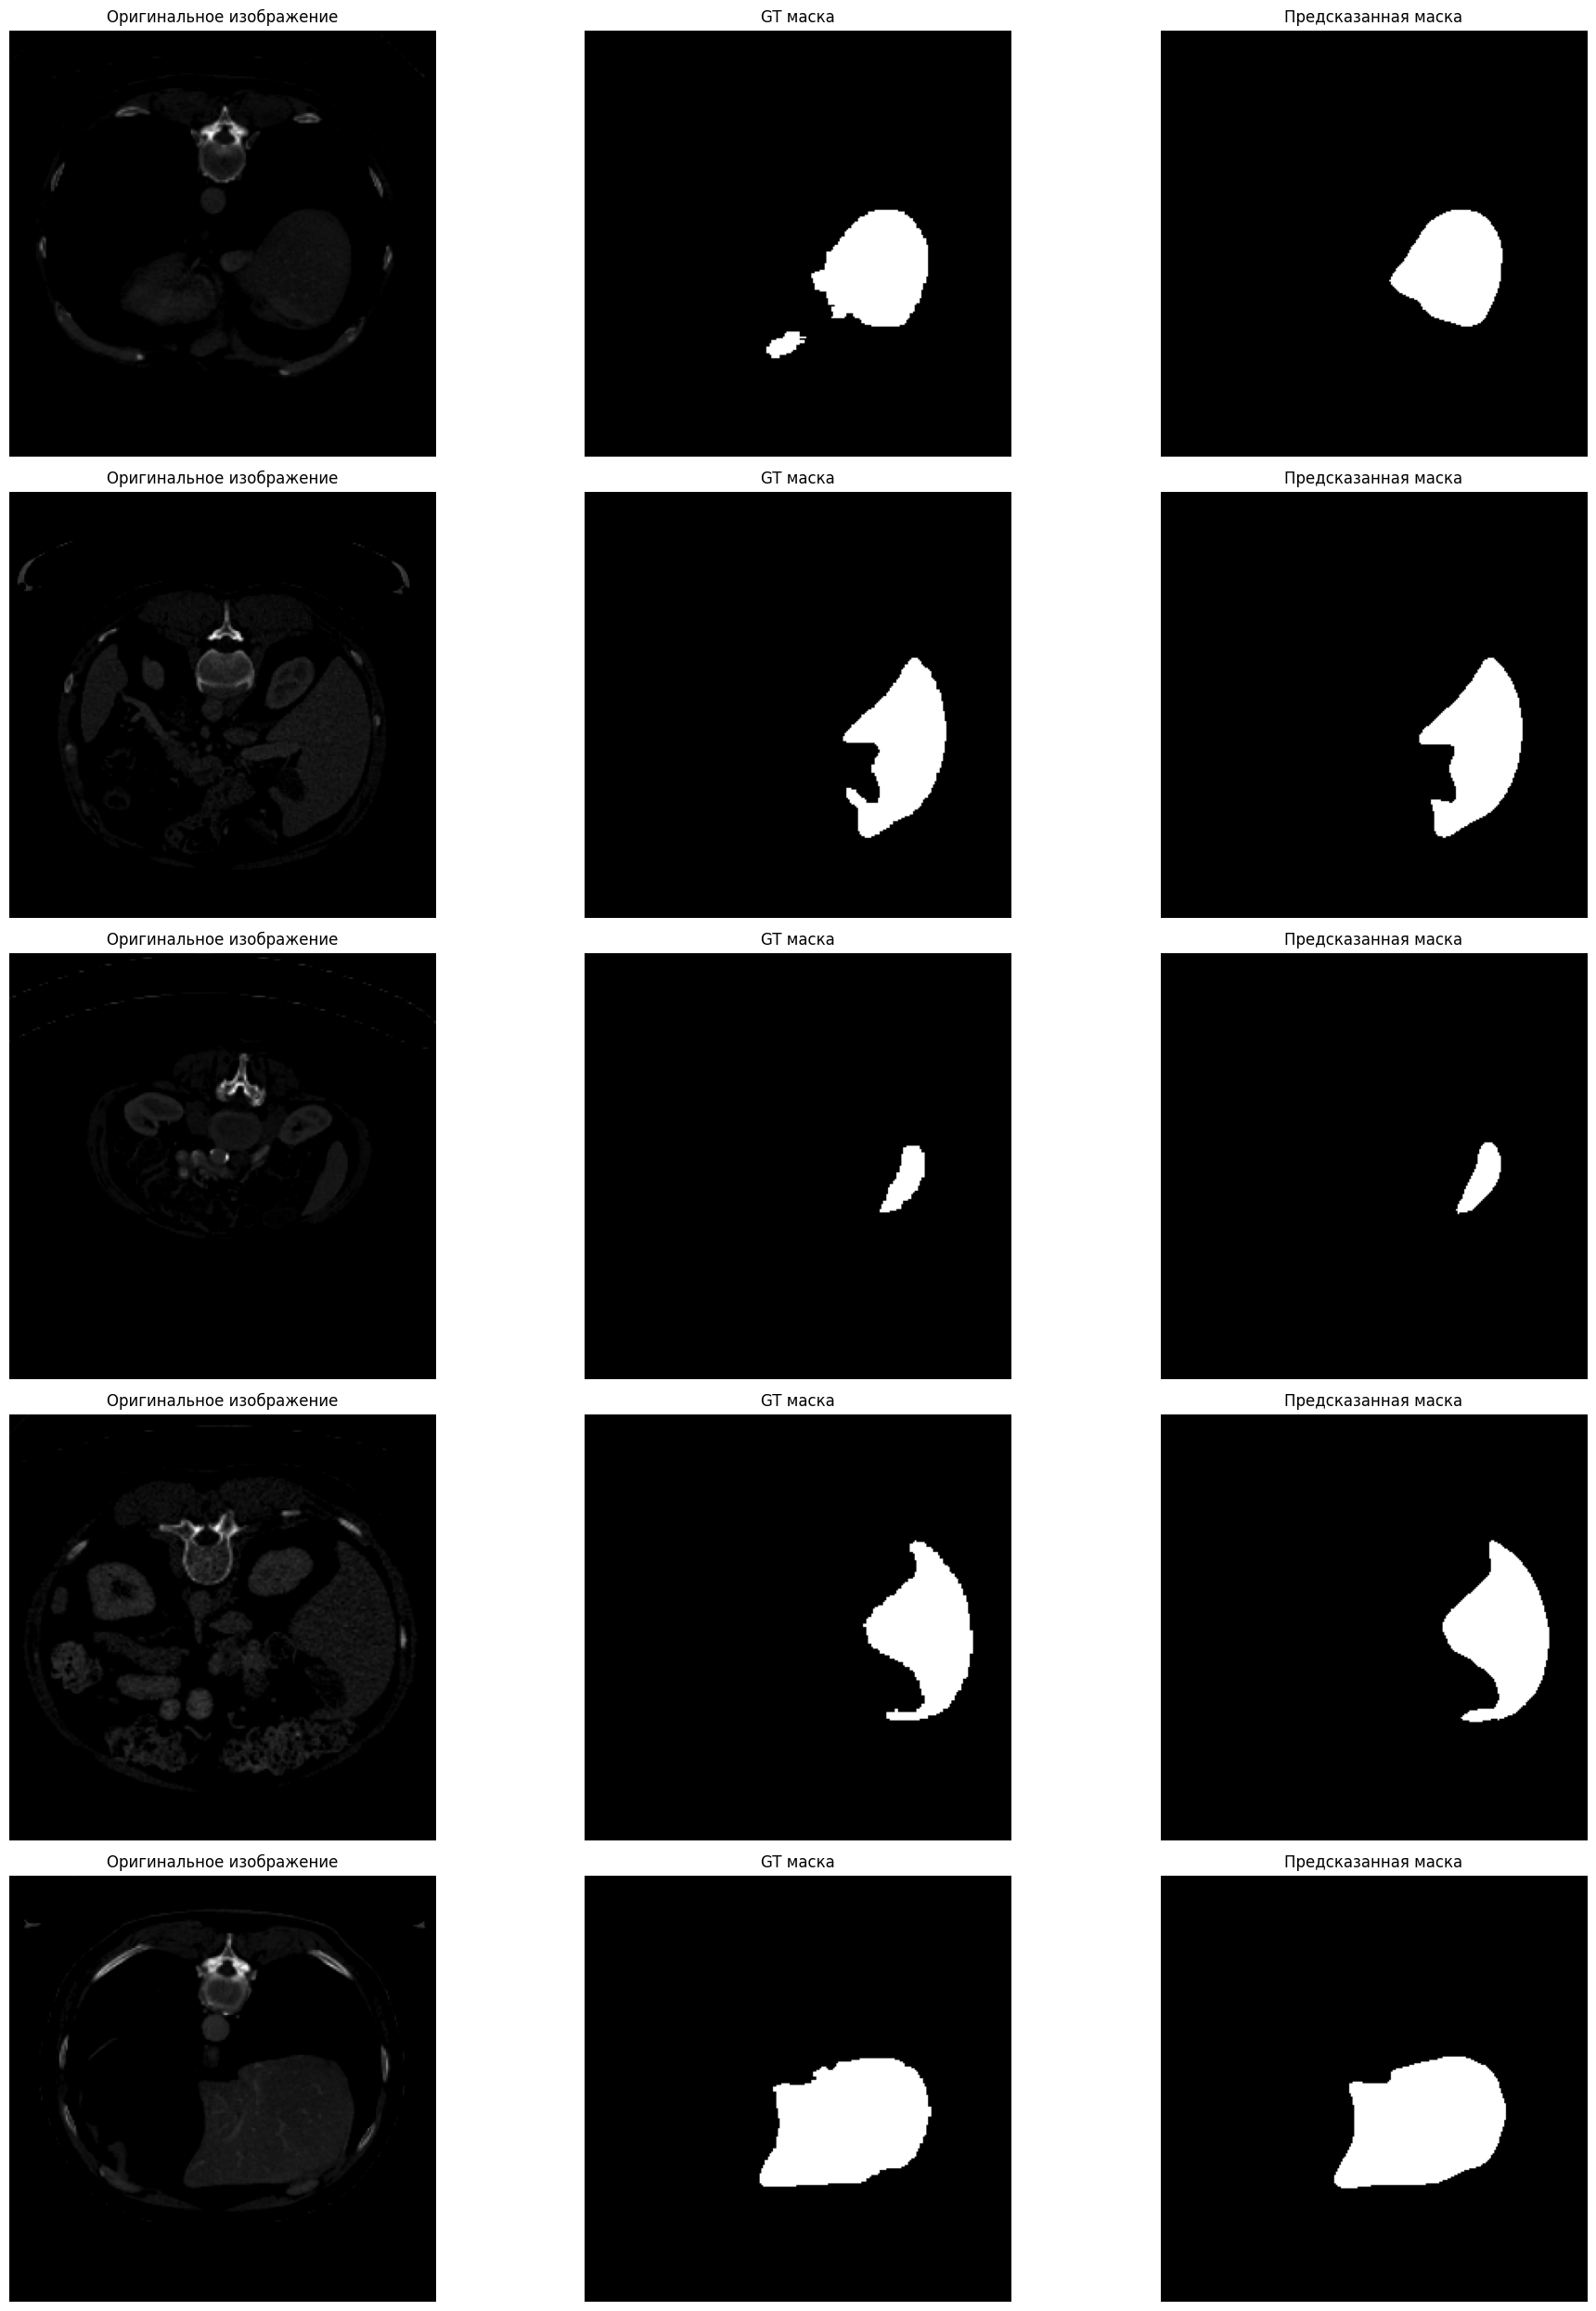

In [ ]:
visualize_dataset(test_dl, model, num_images=5)